<a href="https://colab.research.google.com/github/kovzanok/dls-final-task/blob/main/Final_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Установка зависимостей

In [3]:
!pip install insightface onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.5 MB/s eta 0:00:00


In [25]:
from torch import nn
from insightface.app import FaceAnalysis
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
import cv2
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow

import random
import os

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Подготовка данных

##Архив изображений

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -q /content/drive/MyDrive/img_align_celeba.zip -d /content/celeba/

In [8]:
def get_filenames_os(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

In [9]:
filenames = get_filenames_os('/content/celeba/img_align_celeba')

In [10]:
idx = random.sample(range(len(filenames)), 100)

In [15]:
random_files = [ filenames[i] for i in idx ]

##Разметка "имя изображения  - id"

In [17]:
df = pd.read_csv('/content/drive/MyDrive/identity_CelebA.txt', delim_whitespace=True, header=None,index_col=0)

<ipython-input-17-2280069971>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('/content/drive/MyDrive/identity_CelebA.txt', delim_whitespace=True, header=None,index_col=0)


In [18]:
df.index.name = 'image_name'
df.rename(columns={1:'id'},inplace=True)

In [20]:
filtered_df = df.loc[random_files]
le = LabelEncoder()
filtered_df['encoded_id'] = le.fit_transform(filtered_df['id'])

#Пайплайн

#Детекция лиц

In [43]:
# Инициализируем модель
app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=-1, det_size=(640, 640))  # ctx_id=0 — GPU, -1 — CPU

# Путь к папке с 100 изображениями
image_folder = "/content/celeba/img_align_celeba"
image_paths = [os.path.join(image_folder, fname) for fname in random_files]

# Результаты
all_faces = []

for path in tqdm(image_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = app.get(img)  # список найденных лиц
    all_faces.append({
        'image_path': path,
        'faces': faces  # каждый face — это dict с bbox, landmarks и т.д.
    })

/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


  0%|          | 0/100 [00:00<?, ?it/s]

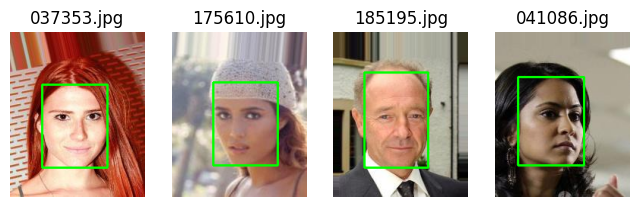

In [56]:
fig = plt.figure(figsize=(8, 8))

for i, idx in enumerate(random.sample(range(len(all_faces)),4)):
    img = cv2.imread(all_faces[idx]['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    for face in all_faces[idx]['faces']:
        x1, y1, x2, y2 = map(int, face.bbox)
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

        fig.add_subplot(1, 4, i+1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(os.path.basename(all_faces[idx]['image_path']))

plt.show()

In [46]:
save_dir = "/content/cropped_faces"
os.makedirs(save_dir, exist_ok=True)

for entry in all_faces:
    image_path = entry['image_path']
    filename = os.path.basename(image_path)  # например, '000001.jpg'

    img = cv2.imread(image_path)

    # Берём только первое лицо (если нужно все — можно изменить)
    face = entry['faces'][0]
    x1, y1, x2, y2 = map(int, face.bbox)

    # Защита от выхода за границы
    h, w = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    face_crop = img[y1:y2, x1:x2]

    save_path = os.path.join(save_dir, filename)
    cv2.imwrite(save_path, face_crop)
